In [1]:
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from joblib import dump,load, Parallel, delayed, parallel_config

In [2]:
import tensorstore as ts
def open_tensor(fpath, driver='zarr', store='file', AWS_param=None, bytes_limit= 100_000_000):
    """Open a tensorstore object.
       driver: Type of file, including zarr, n5, precomputed
       store: Type of source, including file, s3
       AWS_client: Only applicable to s3 store
    """
    kvstore = {"driver": store,"path": fpath}
    if store == 's3':
        bucket,path = split_s3_path(fpath)
        kvstore = {"driver": "s3","bucket": bucket ,"path": path}
        if AWS_param:
            kvstore.update({"aws_region": AWS_param.region})
            if hasattr(AWS_param, "endpoint_url"):
                kvstore.update({"endpoint": AWS_param.endpoint_url})
            cred = {"aws_credentials":{"profile": AWS_param.profile}}
            if hasattr(AWS_param, "credential_file"):
                cred = {"aws_credentials":{"profile": AWS_param.profile, 
                                           "filename": AWS_param.credential_file['filename']}}
            kvstore.update(cred)
    #Load tensorstore array
    dataset_future = ts.open({
         'driver':
             driver,
         'kvstore': kvstore,
     # Use 100MB in-memory cache.
         'context': {
             'cache_pool': {
                 'total_bytes_limit': bytes_limit
             }
             \
         },
         'recheck_cached_data':
         'open',
     })

    return dataset_future.result()

In [8]:
#Open image data and transpose
stack = open_tensor("/ACdata/Users/kevin/ispim_ome_zarr/H17_x55_S32_230412_highres/H17_x55_S32_230412_highres.zarr/highres_Pos53/1/", bytes_limit= 100_000_000)
stack = stack[0,0,:,:,:]

In [9]:
# Get information about the stack dimensions
width, height, num_slices = stack.shape
print(f"Number of slices: {num_slices}")
print(f"Image dimensions: {width}x{height}")

Number of slices: 288
Image dimensions: 21568x288


/home/wanqing.yu/anaconda3/envs/AC/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 994 ms, sys: 879 ms, total: 1.87 s
Wall time: 18.2 s


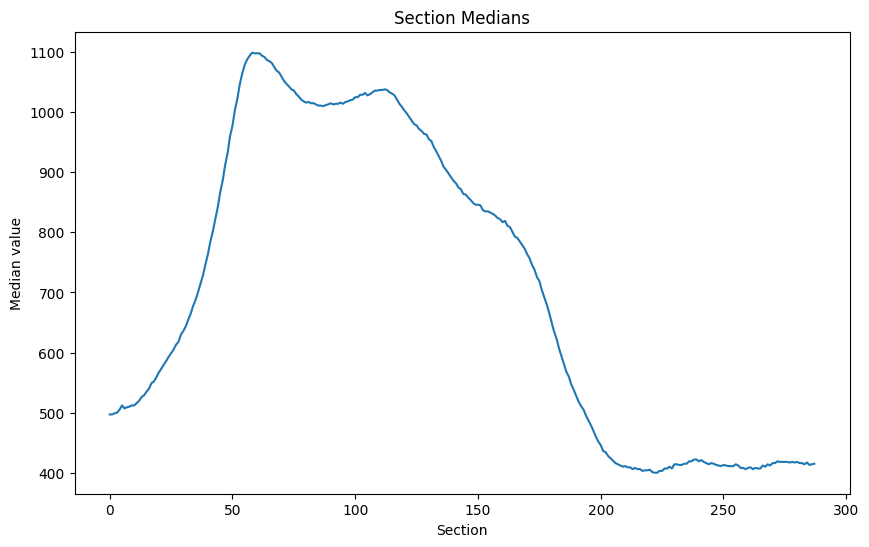

In [10]:
# Calculate the mean intensity of each section
def z_mean_intensity(num,arr,z_slice):
    mean = np.median(arr[:,:,z_slice])
    return([num,mean])
    
slices = list(range(num_slices))
with parallel_config(backend="loky", inner_max_num_threads=1):
    %time res = Parallel(n_jobs=20)(delayed(z_mean_intensity)(num=num, arr=stack, z_slice=z_slice) for num,z_slice in enumerate(slices) )
sorted(res)
section_medians = np.array([x[1] for x in res])

plt.figure(figsize=(10, 6))
plt.plot(section_medians)
plt.title('Section Medians')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()

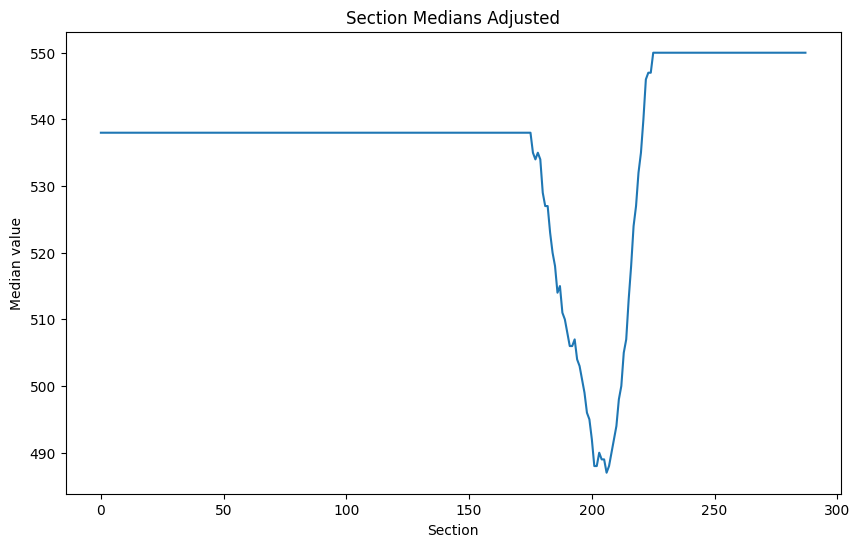

In [6]:
from scipy.signal import find_peaks

# Find peaks of the section_medians array
peaks, _ = find_peaks(section_medians, prominence=40)

section_medians_corrected = section_medians.copy()

# Apply peak value to the surface stacks
section_medians_corrected[0:peaks[0]] = section_medians[peaks[0]]
section_medians_corrected[peaks[-1]:] = section_medians[peaks[-1]]

plt.figure(figsize=(10, 6))
plt.plot(section_medians_corrected)
plt.title('Section Medians Adjusted')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()

In [7]:
# Calculate the desired mean intensity (e.g., the min of section medians)
desired_median = np.min(section_medians_corrected)

# Normalize each section to the desired mean intensity
for i in range(stack.shape[2]):
    print(i)
    normalized_stack[:,:,z_slice].write(((stack[:,:,i].read().result() / section_medians_corrected[i]) * desired_median).astype('uint16')).result()

0


NameError: name 'normalized_stack' is not defined

In [ ]:
# Calculate the desired mean intensity (e.g., the min of section medians)
desired_median = np.min(section_medians_corrected)
normalized_stack = create_tensor("/ACdata/Users/connorl/Image_Files/normalized_stack.zarr", stack.shape, dtype = 'uint16', fill_value=0)

In [ ]:
# Normalize each section to the desired mean intensity
writes = []

for i in range(stack.shape[2]):
    writes.append(normalized_stack[:,:,i].write(((stack[:,:,i] / section_medians_corrected[i]) * desired_median).astype('uint16')))

for write in writes:
    write.result()  

In [ ]:
# Calculate the median intensity of normalized stack
slices = list(range(num_slices))
with parallel_config(backend="loky", inner_max_num_threads=1):
    %time res = Parallel(n_jobs=20)(delayed(z_mean_intensity)(num=num, arr=normalized_stack, z_slice=z_slice) for num,z_slice in enumerate(slices) )
sorted(res)
section_medians_normalized = np.array([x[1] for x in res])

plt.figure(figsize=(10, 6))
plt.plot(section_medians_normalized)
plt.title('Section Medians Normalized')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()